In [78]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date

import file


In [79]:
# Define the ticker symbol
tickerSymbol = 'FNGS'
start = '2023-1-1'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start=start, end=date.today())

In [80]:
gap = 1/60 * 100 # %
option_prices = {
    1: [44/0.5, 62/0.3], # -1500%
    2: [59/0.77],
    4: [49/1.07],
    5: [53/1.5, 58/1.67, 62/1.42],
    6: [44/1.42],
    7: [59/1.92],
    8: [49/1.95],
    9: [53/2.12, 58/2.55],
    11: [59/2.6],
    17: [49/3.28],
    18: [53/3.1, 62/3.7],
    19: [44/2.9],
    21: [49/3.37],
    22: [58/4.6],
    24: [59/4.65],
    30: [49/4.45],
    31: [53/4.8, 62/5.05],
    32: [44/4.15],
    35: [58/5.75],
    36: [44/4.53],
    48: [62/6.45],
    52: [58/7.45],
    54: [59/7.25],
    61: [53/7.45]
}
print('option leverages:')
for w in option_prices:
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}

# normalize values so longer expirations have lower leverage
option_leverage = {k: v for k, v in zip(sorted(option_leverage.keys()), sorted(option_leverage.values(), reverse=True))}

print('mean option leverage, break even:')
for w in option_leverage:
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 1w 88.0 206.7
	 2w 76.6
	 4w 45.8
	 5w 35.3 34.7 43.7
	 6w 31.0
	 7w 30.7
	 8w 25.1
	 9w 25.0 22.7
	11w 22.7
	17w 14.9
	18w 17.1 16.8
	19w 15.2
	21w 14.5
	22w 12.6
	24w 12.7
	30w 11.0
	31w 11.0 12.3
	32w 10.6
	35w 10.1
	36w  9.7
	48w  9.6
	52w  7.8
	54w  8.1
	61w  7.1
mean option leverage, break even:
	 1w 147.3  2.3%
	 2w 76.6  3.0%
	 4w 45.8  3.9%
	 5w 37.9  4.3%
	 6w 31.0  4.9%
	 7w 30.7  4.9%
	 8w 25.1  5.6%
	 9w 23.9  5.9%
	11w 22.7  6.1%
	17w 16.9  7.6%
	18w 15.2  8.3%
	19w 14.9  8.4%
	21w 14.5  8.5%
	22w 12.7  9.5%
	24w 12.6  9.6%
	30w 11.7 10.2%
	31w 11.0 10.7%
	32w 10.6 11.1%
	35w 10.1 11.6%
	36w  9.7 12.0%
	48w  9.6 12.1%
	52w  8.1 14.0%
	54w  7.8 14.5%
	61w  7.1 15.7%
option gap: 1.67%


In [81]:
max_weeks = 100

stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.mean() * 52 / weeks) # annualized

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = stock_changes[weeks:].apply(lambda x: max(-100, (x - gap) * lvr - 100))
        mean_profit = option_profits.mean()
        meanw_profit = option_profits.mean() / weeks # weekly
        median_profit = option_profits.median() / weeks # weekly
        positive_percent = (option_profits > 0).mean() * 100
        option_performance.append([weeks, mean_profit, positive_percent, meanw_profit])
        history[f'Option {weeks}w'] = option_profits # ? * 52 / weeks # annualized

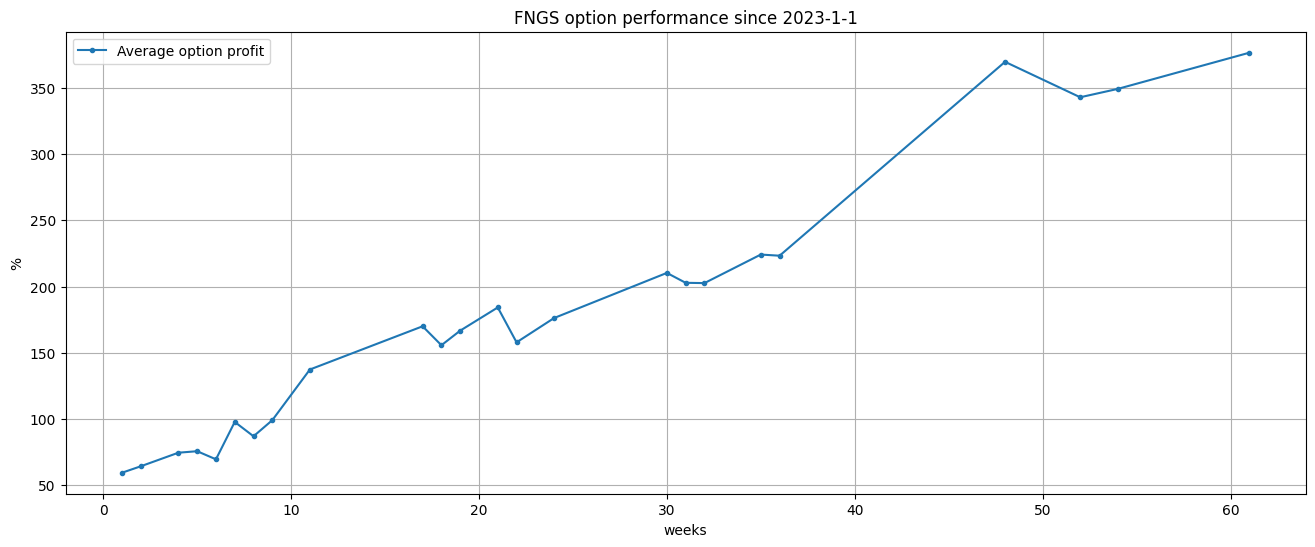

In [82]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_profit = [p[1] for p in option_performance]
plt.plot(option_weeks, option_profit, label='Average option profit', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} option performance since {start}')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

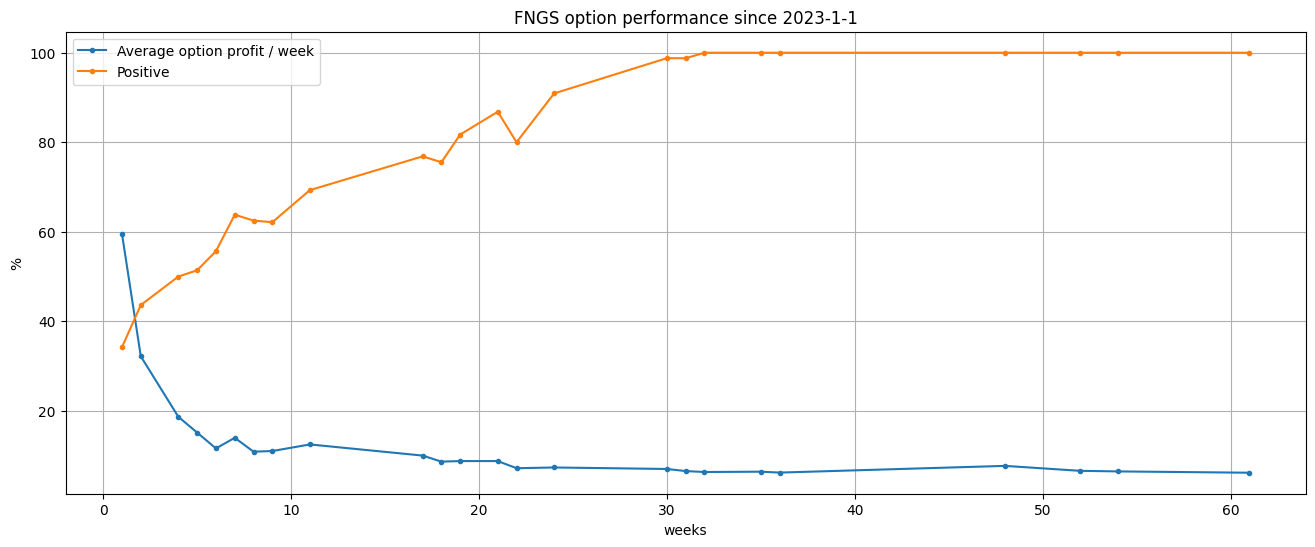

In [83]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
meanw_profit = [p[3] for p in option_performance]
option_positive = [p[2] for p in option_performance]
plt.plot(option_weeks, meanw_profit, label='Average option profit / week', marker='.')
plt.plot(option_weeks, option_positive, label='Positive', marker='.')
# plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.title(f'{tickerSymbol} option performance since {start}')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

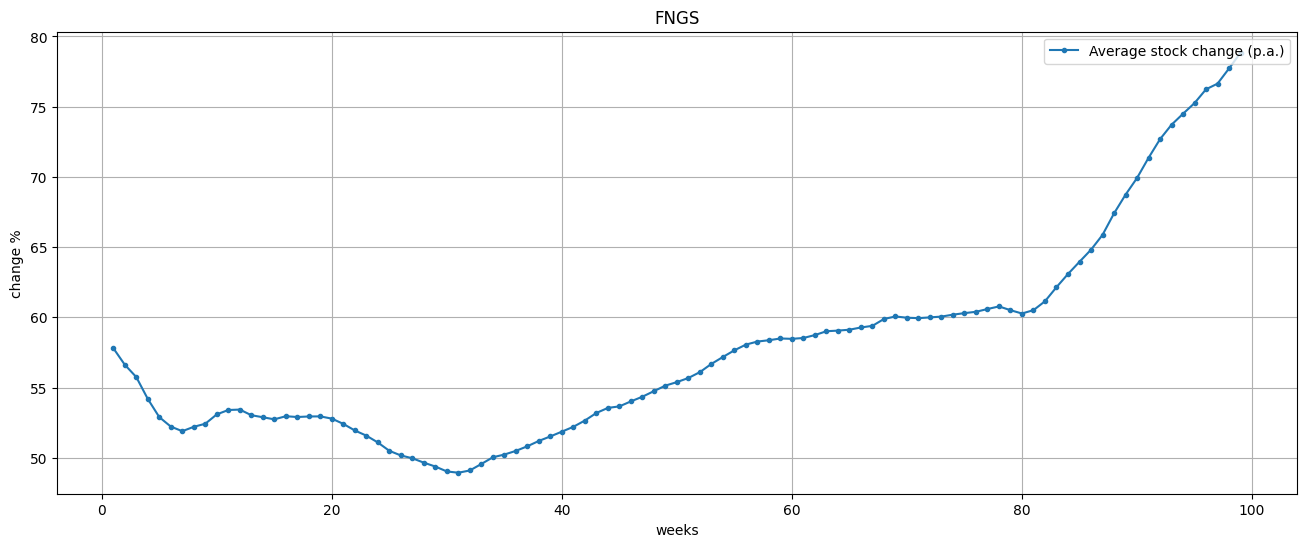

In [84]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Average stock change (p.a.)', marker='.')
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()
